## Librerias

In [54]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score,classification_report
from sklearn.model_selection import TimeSeriesSplit
import optuna
import numpy as np
import shap
import matplotlib.pyplot as plt
import joblib

scaler = RobustScaler()
le = LabelEncoder()


## Lectura del Archivo

In [28]:
fileName= "data_set_integrado_modelo_final_futuro_binario.csv"
path="../franco/"

# Read the CSV file
df = pd.read_csv(path + fileName)

In [29]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2909 entries, 0 to 2908
Data columns (total 76 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id_cotizacion                              2909 non-null   int64  
 1   id_empresa                                 2909 non-null   int64  
 2   fecha                                      2909 non-null   object 
 3   precio_apertura                            2909 non-null   float64
 4   precio_cierre                              2909 non-null   float64
 5   precio_max                                 2909 non-null   float64
 6   precio_min                                 2909 non-null   float64
 7   volumen_operado                            2909 non-null   float64
 8   variacion_porcentaje                       2862 non-null   float64
 9   nombre                                     2909 non-null   object 
 10  label                   

,id_cotizacion,id_empresa,fecha,precio_apertura,precio_cierre,precio_max,precio_min,volumen_operado,variacion_porcentaje,nombre,...,total_noticias_positivas_std_3d,total_noticias_positivas_media_5d,total_noticias_positivas_std_5d,total_noticias_negativas_media_3d,total_noticias_negativas_std_3d,total_noticias_negativas_media_5d,total_noticias_negativas_std_5d,ratio_sent_positivo_negativo,diff_score_sentimiento,label_t_plus_1
0,901,10,2024-01-02,18.90,18.80,19.30,18.70,66824.55,-1.827676,AAPLD,...,3.464102,1.2,2.683282,3.000000,5.196152,1.8,4.024922,-0.481708,6.8366,NO_SUBE
1,902,10,2024-01-03,19.00,18.80,19.15,18.25,81325.30,0.000000,AAPLD,...,6.000000,3.6,5.366563,6.333333,5.507571,3.8,5.215362,-1.119817,11.1142,SUBE
2,903,10,2024-01-04,18.80,18.95,19.05,18.20,97707.20,0.797872,AAPLD,...,3.785939,4.6,4.979960,9.000000,1.000000,5.4,4.979960,-0.408107,6.7009,NO_SUBE
3,904,10,2024-01-05,19.00,18.80,19.25,18.60,201923.66,-0.791557,AAPLD,...,3.785939,5.8,4.266146,9.000000,1.000000,7.2,4.086563,-0.799964,7.9571,SUBE
4,905,10,2024-01-08,19.10,19.35,19.50,18.85,151354.09,2.925532,AAPLD,...,1.527525,7.4,2.792848,10.666667,3.785939,10.2,2.774887,-0.690825,12.1479,NO_SUBE
5,906,10,2024-01-09,19.50,19.25,20.00,19.10,120224.45,-0.516796,AAPLD,...,2.516611,6.8,3.420526,11.333333,3.214550,10.4,2.701851,-0.209733,5.9537,SUBE
6,907,10,2024-01-10,19.75,19.50,19.75,19.10,115249.95,1.298701,AAPLD,...,4.041452,6.6,3.049590,14.333333,4.041452,12.0,4.301163,-0.533878,14.3956,NO_SUBE
7,908,10,2024-01-11,19.70,19.10,19.70,19.00,131784.16,-2.051282,AAPLD,...,7.023769,9.0,5.338539,14.666667,4.163332,13.6,3.911521,-0.925630,18.4250,SUBE
8,909,10,2024-01-12,19.40,19.30,19.50,19.05,75013.05,1.047120,AAPLD,...,3.464102,10.0,5.099020,17.333333,1.154701,15.4,3.286335,-0.560599,15.4312,SUBE
9,910,10,2024-01-15,19.30,19.40,19.40,19.15,74513.10,0.518135,AAPLD,...,6.000000,9.4,5.549775,12.333333,8.144528,13.0,6.480741,-1.097799,4.2600,NO_SUBE


Codifico el target

In [30]:
df['target'] = le.fit_transform(df['label_t_plus_1'])  # SUBE=1, NO_SUBE=0

Tratamiento de valores nulos

In [31]:
sentiment_cols = ['suma_score_sentimiento_positivas', 'suma_score_sentimiento_negativas',
                 'ratio_sent_positivo_negativo', 'diff_score_sentimiento']
for col in sentiment_cols:
    df[col] = df[col].fillna(df[col].median())

Agrego dos features adicionales

In [32]:
df['sentimiento_volatilidad'] = df['suma_score_sentimiento_positivas'] * df['precio_cierre_std_5d']
df['momentum_compuesto'] = df['tendencia_precio_5d'] * df['volumen_operado_media_5d']

Selecciono FEATURES claves

In [33]:
features = [
    # Precios y volumen
    'precio_cierre', 'volumen_operado', 'precio_cierre_lag_1', 
    'precio_cierre_media_5d', 'precio_cierre_std_5d', 'variacion_porcentaje',
    
    # Sentimiento
    'suma_score_sentimiento_positivas', 'ratio_sent_positivo_negativo', 
    'suma_score_sentimiento_positivas_lag_1', 'diff_score_sentimiento',
    
    # Temporales
    'dia_semana', 'es_fin_de_mes',
    
    # Tendencias e interacciones
    'tendencia_precio_5d', 'sentimiento_volatilidad', 'momentum_compuesto'
]

target = 'target'

# Modelado de Lightgbm

In [34]:
# División temporal (80% train, 20% test)
train_size = int(0.8 * len(df))
X_train, X_test = df[features].iloc[:train_size], df[features].iloc[train_size:]
y_train, y_test = df[target].iloc[:train_size], df[target].iloc[train_size:]

# Escalar features numéricas (opcional para LightGBM)

In [36]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Optimizacion de Hipeparametros

In [37]:
def optimize_hyperparams(X_train, y_train, X_test, y_test, n_trials=30):
    def objective(trial):
        params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'boosting_type': 'dart',
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
            'lambda_l1': trial.suggest_float('lambda_l1', 0, 5),
            'lambda_l2': trial.suggest_float('lambda_l2', 0, 5),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
            'verbose': -1
        }
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return f1_score(y_test, y_pred)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    return study.best_params

In [38]:
# Ejecutar optimización (comentar si no se desea)
best_params = optimize_hyperparams(X_train_scaled, y_train, X_test_scaled, y_test)
print("Mejores hiperparámetros:", best_params)

[I 2025-05-03 15:12:07,551] A new study created in memory with name: no-name-036d8b4b-19dd-4bc8-b1a3-90bd4883e97e
/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-03 15:12:07,917] Trial 0 finished with value: 0.5261194029850746 and parameters: {'num_leaves': 71, 'learning_rate': 0.04912324911808033, 'feature_fraction': 0.9260459428508636, 'bagging_fraction': 0.6088754057582632, 'lambda_l1': 1.7669922281435175, 'lambda_l2': 3.6862435633429396, 'min_data_in_leaf': 13}. Best is trial 0 with value: 0.5261194029850746.
/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid f

Mejores hiperparámetros: {'num_leaves': 58, 'learning_rate': 0.2205345310332203, 'feature_fraction': 0.9519088728687508, 'bagging_fraction': 0.9226378353074403, 'lambda_l1': 3.4294755534982664, 'lambda_l2': 2.4065476672431036, 'min_data_in_leaf': 23}


In [40]:
# Entrenar modelo final
final_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'dart',
    'num_leaves': 40,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbose': -1
}

model = lgb.LGBMClassifier(**final_params)
model.fit(X_train_scaled, y_train, 
          eval_set=[(X_test_scaled, y_test)],
          eval_metric='binary_logloss',
          callbacks=[
                        lgb.early_stopping(stopping_rounds=50),   # detiene si no mejora en 50 iter
                        lgb.log_evaluation(period=10)             # imprime log cada 10 iter
                    ]
)


# Entrenamos usando callbacks en lugar de early_stopping_rounds directo
# model.fit(
#     X_train,
#     y_train,
#     eval_set=[(X_test, y_test)],
#     eval_metric='binary_logloss',
#     callbacks=[
#         lgb.early_stopping(stopping_rounds=50),   # detiene si no mejora en 50 iter
#         lgb.log_evaluation(period=10)             # imprime log cada 10 iter
#     ]
# )

/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[10]	valid_0's binary_logloss: 0.673857
[20]	valid_0's binary_logloss: 0.667805
[30]	valid_0's binary_logloss: 0.661709
[40]	valid_0's binary_logloss: 0.660597
[50]	valid_0's binary_logloss: 0.661173
[60]	valid_0's binary_logloss: 0.660694
[70]	valid_0's binary_logloss: 0.661674
[80]	valid_0's binary_logloss: 0.661512
[90]	valid_0's binary_logloss: 0.66215
[100]	valid_0's binary_logloss: 0.662163


LGBMClassifier(boosting_type='dart', feature_fraction=0.8, lambda_l1=0.1,
               lambda_l2=0.1, learning_rate=0.05, metric='binary_logloss',
               num_leaves=40, objective='binary', verbose=-1)

## Evaluacion

/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Reporte de Clasificación:
              precision    recall  f1-score   support

     NO_SUBE       0.66      0.60      0.63       322
        SUBE       0.55      0.62      0.58       260

    accuracy                           0.60       582
   macro avg       0.60      0.61      0.60       582
weighted avg       0.61      0.60      0.61       582



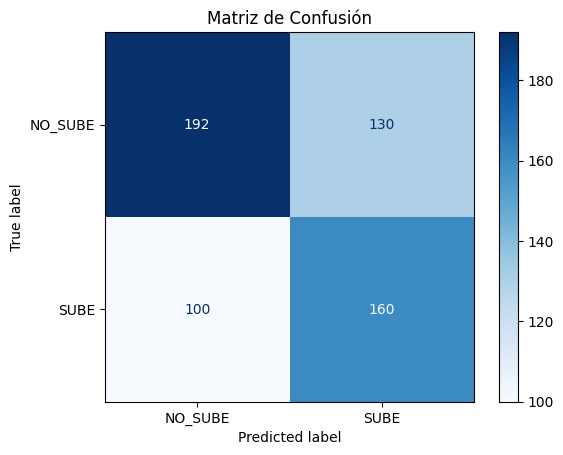

In [44]:
# ----------------------------------------------------------
# 4. EVALUACIÓN DEL MODELO
# ----------------------------------------------------------
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probabilidades para SUBE

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['NO_SUBE', 'SUBE']))

# Matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NO_SUBE', 'SUBE'])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

## Optimizacion de hiperparametros con OPTUNA

# Interpretacion con SHAP (Shapley Additive Explanations)
Esta libreria es un marco teorico que se utiliza para explicar el resultado de cualquier modelo de ML.

In [48]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Feature importance

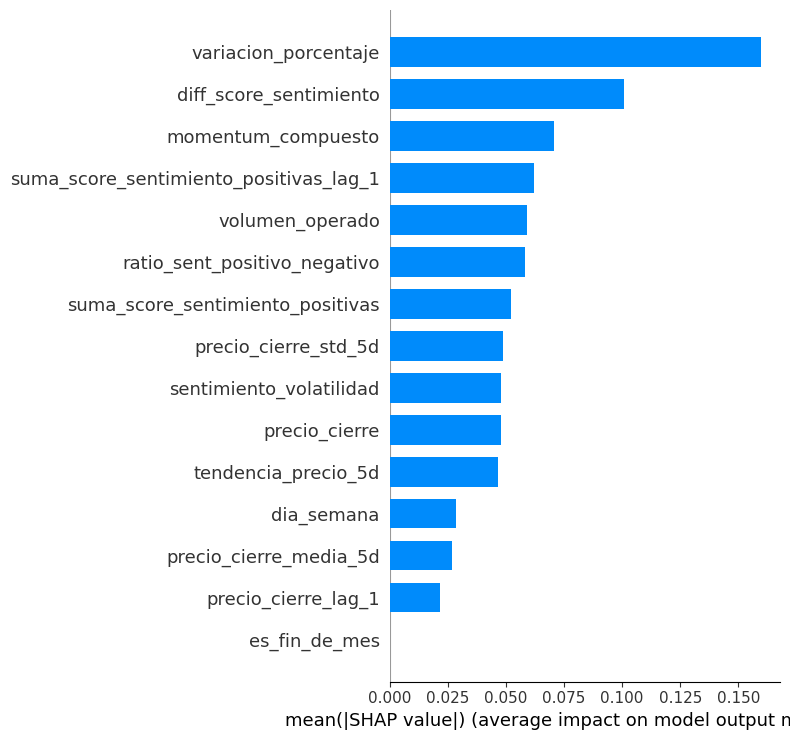

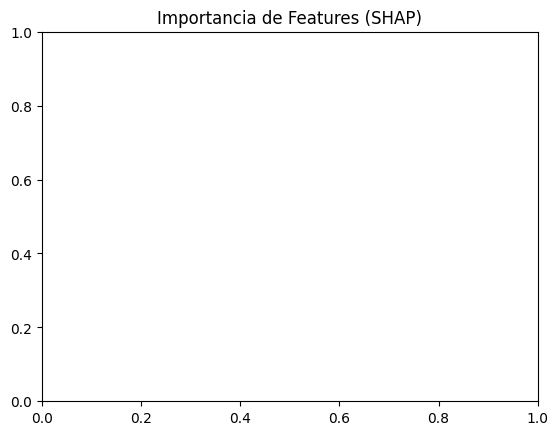

In [50]:
shap.summary_plot(shap_values, X_test_scaled, feature_names=features, plot_type="bar")
plt.title("Importancia de Features (SHAP)")
plt.show()


AssertionError: 'shap_values' and 'features' values must have the same number of rows!

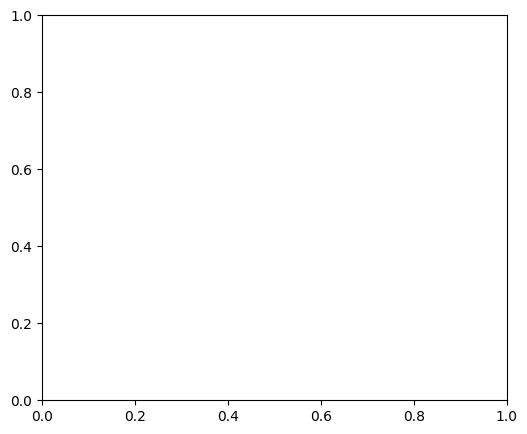

In [51]:
# Dependencia para una feature clave (ej: sentimiento)
shap.dependence_plot("suma_score_sentimiento_positivas", shap_values[1], X_test_scaled, 
                     feature_names=features, interaction_index=None)
plt.title("Dependencia del Sentimiento Positivo")
plt.show()

# 6. BACKTESTING SIMPLE

In [52]:
df_test = df.iloc[train_size:].copy()
df_test['prediccion'] = y_proba
df_test['decision'] = np.where(df_test['prediccion'] > 0.6, 1, 0)  # Umbral ajustable

# Calcular retorno acumulado de la estrategia
df_test['retorno_estrategia'] = df_test['decision'] * df_test['variacion_porcentaje'].shift(-1)

print("\nResultados de Backtesting:")
print(f"Retorno acumulado: {df_test['retorno_estrategia'].sum():.2f}%")
print(f"Cantidad de operaciones: {df_test['decision'].sum()}")


Resultados de Backtesting:
Retorno acumulado: 62.66%
Cantidad de operaciones: 86


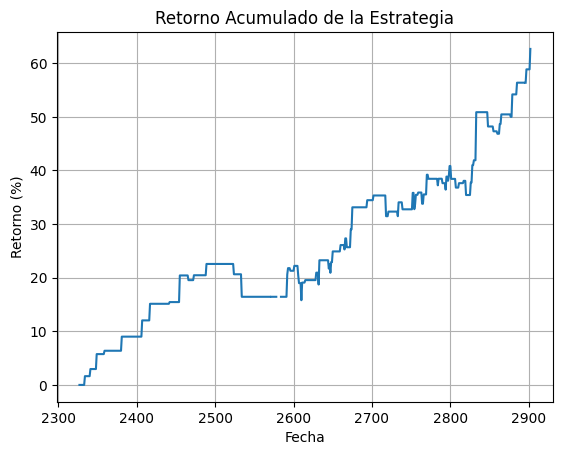

In [53]:
# Gráfico de retornos acumulados
df_test['retorno_acumulado'] = df_test['retorno_estrategia'].cumsum()
df_test['retorno_acumulado'].plot(title='Retorno Acumulado de la Estrategia')
plt.xlabel('Fecha')
plt.ylabel('Retorno (%)')
plt.grid()
plt.show()

# 7. GUARDAR MODELO Y FEATURES

In [ ]:
joblib.dump(model, 'modelo_lightgbm.pkl')
joblib.dump(scaler, 'scaler.pkl')
pd.Series(features).to_csv('features_seleccionadas.csv', index=False)

print("\n¡Modelo entrenado y guardado correctamente!")


¡Modelo entrenado y guardado correctamente!
